In [46]:
%matplotlib inline
import json
import urllib2
import os
from tables import open_file
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 
from alleninf.api import get_probes_from_genes
from alleninf.data import get_values_at_locations
from alleninf.api import get_mni_coordinates_from_wells#
from alleninf.analysis import fixed_effects, approximate_random_effects, bayesian_random_effects

pd.options.display.max_rows = 2000
pd.options.display.max_columns = 999
sns.set_style('white')

api_url = "http://api.brain-map.org/api/v2/data/query.json"

statsdir = '/scr/malta3/workspace/project_iron/statistics'
statsdir = '/Users/kanaan/SCR/workspace/tmp'
stat_map = os.path.join(statsdir, 'randomise_tstat1.nii.gz')
mean_map = os.path.join(statsdir, 'QSM_mean.nii.gz')
mask = None

In [9]:
down_regulated_genes = { # Clardy et al. (2006). Acute and chronic effects of developmental iron deficiency 
                         # on mRNA expression patterns in the brain. Journal of Neural Transmission, 71, 173–96. 
                         # http://www.ncbi.nlm.nih.gov/pubmed/17447428
                    'THRSP'      :  'thyroid hormone responsive protein',
                    #''          :  'Rattus norvegicus Nclone10 mRNA',
                    'TF'         :  'transferrin',
                    'MAL'        :  'mal, T-cell differentiation protein',
                    'KLK6'       :  'kallikrein-related peptidase 6', 
                    'HOMER1'     :  'homer homolog 1 (Drosophila), neuronal immediate early gene',
                    'MOBP'       :  'myelin-associated oligodendrocytic basic protein',
                    'APOD'       :  'apolipoprotein D',
                    #''          :  'Rat troponin-c mRNA'
                    'MOG'        :  'myelin oligodendrocyte glycoprotein',
                    'CRYAB'      :  'crystallin, alpha B',
                    #'Af6'       :  'afadin',
                    #''           :  'Rattus norvegicus retroviral-like ovarian specific transcript 30-1 mRNA',
                    'APOC1'      :  'apolipoprotein C-I',
                    'CA2'        :  'carbonic anhydrase II',
                    'RASGRP1'    :  'RAS guanyl releasing protein 1',
                    'STMN4'      :  'stathmin-like 4',
                    #'Rnf28'      :  'ring finger protein 28',
                    'LYZ'        :  'lysozyme', 
                    #'LOC309574' :  'olfactory receptor',
                    'GSTM1'      :  'glutathione S-transferase mu 1', 
                    'CTSS'       :  'cathepsin S', 
                    'DCK'        :  'deoxycytidine kinase',
                    #''           :  'Rattus norvegicus similar to S-100 protein, alpha chain (LOC295214), mRNA',
                    #''           :  'Rat PMSG-induced ovarian mRNA, 3’sequence, N1'
                       }

iron_homeostasis_gene_set = { # http://amp.pharm.mssm.edu/Harmonizome/gene_set/Iron+Homeostasis(Mus+musculus)/Wikipathways+Pathways
                    'FTH1': 'ferritin heavy polypeptide 1',
                    'FTL' : 'ferritin light polypeptide',
                    'HFE' :'hemochromatosis',
                    'HFE2' :'hemochromatosis type 2 (juvenile)',
                    'IL1A' :'interleukin 1, alpha',
                    'IL6' :'interleukin 6',
                    'IL6R' :'interleukin 6 receptor',
                    'IREB2':'iron-responsive element binding protein 2',
                    'SLC40A1':'solute carrier family 40 (iron-regulated transporter), member 1',
                    'TF':'transferrin',
                    'TFR2':'transferrin receptor 2',
                    'TNF' : 'tumor necrosis factor',
}


DA_metabolism_gene_set = { # http://amp.pharm.mssm.edu/Harmonizome/gene_set/Dopamine+metabolism(Homo+sapiens)/Wikipathways+Pathways
                    'COMT': 'catechol-O-methyltransferase',
                    'DDC': 'dopa decarboxylase (aromatic L-amino acid decarboxylase)',
                    'MAOA': 'monoamine oxidase A',
                    'MAOB': 'monoamine oxidase B',
                    'NQO1': 'NAD(P)H dehydrogenase, quinone 1',
                    'PPP2CA': 'protein phosphatase 2, catalytic subunit, alpha isozyme',
                    'PPP2CB': 'protein phosphatase 2, catalytic subunit, beta isozyme',
                    'PRKACA': 'protein kinase, cAMP-dependent, catalytic, alpha',
                    'PRKACB': 'protein kinase, cAMP-dependent, catalytic, beta',
                    'PRKACG': 'protein kinase, cAMP-dependent, catalytic, gamma',
                    #'SOD1': 'superoxide dismutase 1, soluble',
                    'TH': 'tyrosine hydroxylase',
                    'TYR': 'tyrosinase ',
                }

glu_metabolism_gene_set =  { #http://software.broadinstitute.org/gsea/msigdb/cards/REACTOME_GLUTAMATE_NEUROTRANSMITTER_RELEASE_CYCLE
                'UNC13B' : 'unc-13 homolog B (C. elegans)',
                'RIMS1' : 'regulating synaptic membrane exocytosis 1',
                'GLS2' : 'glutaminase 2 (liver, mitochondrial)',
                'GLS' : 'glutaminase',
                'SLC38A2' : 'solute carrier family 38, member 2',
                'SLC17A7' : 'solute carrier family 17 (sodium-dependent in...',
                'RAB3A' : 'RAB3A, member RAS oncogene family',
                'SLC1A1' : 'solute carrier family 1 (neuronal/epithelial ...',
                'SLC1A6' : 'solute carrier family 1 (high affinity aspart...',
                'SLC1A7' : 'solute carrier family 1 (glutamate transporte...',
                'SNAP25' : 'synaptosomal-associated protein, 25kDa',
                'STX1A' : 'syntaxin 1A (brain)',
                'STXBP1' : 'syntaxin binding protein 1',
                'VAMP2' : 'vesicle-associated membrane protein 2 (synapt...',
                'SYT1' : 'synaptotagmin I'}

gaba_metabolism_gene_set =  { #http://software.broadinstitute.org/gsea/msigdb/cards/BIOCARTA_GABA_PATHWAY
                'GPHN': 'gephyrin',
                'GABARAP': 'GABA(A) receptor-associated protein',
                'DNM1': 'dynamin 1',
                'GABRA1': 'gamma-aminobutyric acid (GABA) A receptor, al...',
                'GABRA2': 'gamma-aminobutyric acid (GABA) A receptor, al...',
                'GABRA3': 'gamma-aminobutyric acid (GABA) A receptor, al...',
                'GABRA4': 'gamma-aminobutyric acid (GABA) A receptor, al...',
                'GABRA5': 'gamma-aminobutyric acid (GABA) A receptor, al...',
                'GABRA6': 'gamma-aminobutyric acid (GABA) A receptor, al...',
                'SRC': 'v-src sarcoma (Schmidt-Ruppin A-2) viral onco...'
                }

astrocyte_neuron_metabolic_gene_set = [ # de Leeuw, C.,etal (2015). Involvement of astrocyte metabolic coupling 
                                        # in Tourette syndrome pathogenesis. European Journal of Human Genetics, 
                                        # 23(August 2014), 1–4. https://doi.org/10.1038/ejhg.2015.22
                                       'ME1', 'ALDH5A1', 'GBE1', 'GALM', 'PYGL', 'CPS1','PFKFB3', 
                                       'PYGB', 'IDH2', 'ENO1','PPP1R1A', 'MDH2', 'CS','PYGM', 'PGM3',
                                       'PHKG1', 'SLC3A2', 'PFKFB4', 'KHK','LDHB', 'PCK2','SLC2A8', 
                                       'PGM2', 'GPT','AKR1B1', 'NANS', 'PDK4','OGDHL','DHTKD1', 
                                       'PFKM', 'PGM1', 'PC','AGL'
                                      ]


glu_synpase_gene_set = [ # Lennington, et.al (2016). Transcriptome Analysis of the Human Striatum in Tourette Syndrome. 
                        # Biological Psychiatry, 79(5), 372–382. https://doi.org/10.1016/j.biopsych.2014.07.018# 
                        # Tuquoise module Glutamatergic synapse - Homo sapiens (human)
                        'PPP3R1', 'GRIA2', 'GNAO1', 'GRIA1', 'GRIK5', 'GLUL', 'GLS', 'DLG4', 'CACNA1A', 
                        'CACNA1D', 'SHANK2', 'DLGAP1', 'GRM8', 'GRIA3', 'HOMER1', 'GRM5', 'GRIN1', 'GRM7', 
                        'GRM1', 'MAPK1', 'PLCB1', 'SLC38A1', 'GNB5', 'PRKCB', 'GNB1', 'PRKCG', 'GRM4', 'ITPR1', 
                        'SHANK3', 'PPP3CB', 'ADCY5', 'ADCY1', 'ADCY3', 'GRIK4', 'ADCY9', 'GNG7', 'GNG4', 'GRIN2A', 
                        'PRKACA', 'GNG3', 'PPP3CA', 'SLC1A6', 'GLS2'
                       ]
    


In [10]:
def return_probe_expression(gene_probes_dict, geneset_name):
    
    dfs   = []
    genes = gene_probes_dict.keys()
    
    if not os.path.isfile(os.path.join(statsdir, 'AHBA_%s.csv'%geneset_name)):
    
        print 'Fetching normalized gene expression values for:', genes
        print ''
        for gene in genes:
            probe_ids = ["'%s'" % probe_id for probe_id in gene_probes_dict[gene].keys()]
            print 'Probe IDs for Gene %s = %s' % (gene, probe_ids)

            api_query = api_url + "?criteria=service::human_microarray_expression[probes$in%s]" % (','.join(probe_ids))
            data = json.load(urllib2.urlopen(api_query))
            print api_query

            cols = ['top_struct','struct_name','struct_id', 'donor_names', 'coords_native']
            probe_cols = ['%s_'%gene + str(i) for i in gene_probes_dict[gene].values()]
            cols = cols + probe_cols
            well_ids = [str(sample["sample"]["well"]) for sample in data["msg"]["samples"]]
            df   = pd.DataFrame(index = well_ids, columns = cols)

            df['top_struct']     = [sample["top_level_structure"]["name"] for sample in data["msg"]["samples"]]
            df['struct_id']      = [sample["structure"]["id"] for sample in data["msg"]["samples"]]
            df['struct_name']    = [sample["structure"]["name"] for sample in data["msg"]["samples"]]
            df['donor_names']    = [sample["donor"]["name"]for sample in data["msg"]["samples"]]
            df['coords_native']  = [sample["sample"]["mri"] for sample in data["msg"]["samples"]]

            for i, probe_id in enumerate(gene_probes_dict[gene].values()):
                df['%s_%s'%(gene,probe_id)] = [float(expression_value) for expression_value in data["msg"]["probes"][i]["expression_level"]]

            dfs.append(df)

        # concat all probe expression dataframes
        df = pd.concat(dfs,axis =1).T.groupby(level=0).first().T

        # decompose probe expression values
        all_probes =  ['%s_'%gene + str(i) for gene in gene_probes_dict.keys() for i in gene_probes_dict[gene].values()]

        df['Mean'] = df[all_probes].mean(axis=1)
        df['Median'] = df[all_probes].median(axis=1)

        from sklearn.decomposition import TruncatedSVD
        pca = TruncatedSVD(n_components=1)
        pca.fit(np.array(np.asarray([df[probe] for probe in all_probes])))
        df['PCA'] = pca.components_[0,:]

        package_directory = '/Users/kanaan/SCR/Github/alleninf/alleninf'
        #package_directory = '/scr/malta1/Software/anaconda/envs/awesome/lib/python2.7/site-packages/alleninf'
        mni = pd.read_csv(os.path.join(package_directory, "data", "corrected_mni_coordinates.csv"), 
                            header=0, index_col=0)
        mni.index = mni.index.map(unicode) 
        df_concat = pd.concat([df,mni], axis = 1 ).to_csv(os.path.join(statsdir, 'AHBA_%s.csv'%geneset_name))
    
    return pd.read_csv(os.path.join(statsdir, 'AHBA_%s.csv'%geneset_name),index_col=0)


def get_expression_df(genes, geneset_name):
    gene_probes = {}
    for gene in genes:
        gene_probes[gene] = get_probes_from_genes(gene)
        
    df = return_probe_expression(gene_probes,geneset_name)
    return df 
    


# Extract Iron gene set 

In [11]:
df_iron = get_expression_df(iron_homeostasis_gene_set.keys(), 'iron_homeostasis')

In [12]:
df_iron.head()

,FTH1_A_24_P919330,FTH1_A_32_P111565,FTH1_A_32_P820503,FTL_A_23_P50498,FTL_A_23_P50504,FTL_A_32_P155247,FTL_A_32_P158433,FTL_CUST_4420_PI416261804,HFE2_A_23_P86315,HFE2_CUST_14045_PI416261804,HFE2_CUST_14048_PI416261804,HFE2_CUST_14051_PI416261804,HFE2_CUST_14052_PI416261804,HFE_A_23_P145204,HFE_A_23_P342009,HFE_A_24_P103448,HFE_A_24_P111996,HFE_A_24_P289648,HFE_A_24_P354748,IL1A_A_23_P72096,IL1A_CUST_16163_PI416261804,IL6R_A_24_P379413,IL6R_CUST_14998_PI416261804,IL6_A_23_P71037,IL6_CUST_15487_PI416261804,IREB2_A_23_P106497,IREB2_A_24_P188005,IREB2_A_32_P421898,SLC40A1_A_23_P102391,SLC40A1_A_32_P151454,TFR2_A_23_P122896,TFR2_CUST_14038_PI416261804,TF_A_23_P212500,TF_A_23_P212508,TF_A_32_P42137,TNF_A_23_P376488,TNF_A_24_P50759,coords_native,donor_names,struct_id,struct_name,top_struct,Mean,Median,PCA,corrected_mni_x,corrected_mni_y,corrected_mni_z
1001,11.6052,13.6098,13.8664,11.0665,10.1561,10.4538,6.6165,13.6209,1.7583,1.5450,2.5337,1.5296,1.4950,1.5508,1.5572,1.5096,2.6230,1.9797,3.5558,2.4057,1.5398,4.4187,3.4631,1.4957,2.1803,8.1842,1.4767,1.6009,5.7264,1.5221,5.6650,2.5472,13.9486,9.4268,1.4767,3.2833,2.7505,"[66, 46, 97]",H0351.2001,4033,"middle frontal gyrus, right, superior bank of ...",frontal lobe,5.020124,2.6230,0.015953,29.911739,-2.115836,46.858706
1002,11.4327,14.1971,14.2205,11.3791,10.6794,10.6520,6.6735,14.1435,1.7940,1.7348,2.3749,1.9142,2.1715,1.8449,1.6734,1.4767,3.9782,1.5221,1.5652,1.9969,1.9459,4.7540,3.9363,1.7630,2.2517,8.1055,1.6625,1.8012,6.0338,1.7633,6.3665,1.6042,14.1906,10.2928,2.7480,2.5042,4.2329,"[124, 40, 89]",H0351.2001,4031,"middle frontal gyrus, left, inferior bank of g...",frontal lobe,5.226514,2.5042,0.016513,-34.143679,3.115101,53.592671
1003,11.6800,13.7151,13.8130,11.5674,10.6704,10.6987,6.5169,13.9311,1.9174,1.6837,2.0963,1.8846,1.5686,1.8991,1.8696,1.5740,3.5114,2.2100,2.4094,1.9145,1.6742,4.1628,3.1540,2.9965,2.2156,8.4535,1.7140,1.9080,5.1996,1.8274,5.6247,1.7364,12.7086,8.1329,1.5252,3.2262,4.1010,"[34, 118, 109]",H0351.2001,4154,"inferior temporal gyrus, right, lateral bank o...",temporal lobe,5.067346,2.9965,0.015887,63.768605,-40.606923,-27.030654
1004,11.0197,13.7976,13.8347,11.5105,10.3609,10.5455,6.5338,14.1227,1.9647,1.7494,2.3228,1.9238,1.6714,1.8879,1.7716,2.5628,3.9728,1.6885,2.6065,1.9057,1.6728,3.7809,3.3852,2.7408,2.1531,8.3325,1.7033,1.7336,5.1777,1.7892,6.3483,1.8428,11.8414,7.6308,1.4957,2.7726,4.0023,"[143, 122, 105]",H0351.2001,4150,"inferior temporal gyrus, left, lateral bank of...",temporal lobe,5.031251,2.7408,0.015656,-55.572538,-39.520167,-31.188580
1005,10.7983,13.6835,13.8894,11.3100,9.7466,10.1285,6.4039,13.8226,1.8947,1.6577,2.5168,1.7684,1.5443,1.7926,2.1896,2.3797,4.9600,1.7976,2.0615,1.7514,1.6501,4.2623,3.2054,1.6911,2.6579,8.5986,1.5910,1.8515,5.4620,1.6849,6.2336,1.7066,13.2051,8.5525,1.5268,1.4767,3.2756,"[96, 67, 90]",H0351.2001,4231,"cingulate gyrus, parietal part, left, inferior...",cingulate gyrus,4.992670,2.5168,0.015707,-2.423746,-2.759299,27.899077


# Extract CLARDY_Iron_down_reg gene set 

In [13]:
df_iron_down = get_expression_df(down_regulated_genes.keys(), 'iron_downreg')

# Extract Dopamine Gene set 

In [14]:
df_da = get_expression_df(DA_metabolism_gene_set.keys(), 'dopamine')

# Extract Glutamatergic Gene set 


In [15]:
df_glu = get_expression_df(glu_metabolism_gene_set.keys(), 'glutamate')

# Extract GABAergic Gene set 


In [16]:
df_gaba = get_expression_df(gaba_metabolism_gene_set.keys(), 'gaba')

# Extract Astrocyte-neuronal metabolic coupling gene set 

In [17]:
df_anmc = get_expression_df(astrocyte_neuron_metabolic_gene_set, 'anmc')

# Extract Glu synpase Lennington gene set 

In [18]:
df_glusyn = get_expression_df(glu_synpase_gene_set, 'glu_syn')

# Put gene-set principal components into one dataframe

In [19]:
df  = pd.DataFrame(index = df_iron.index, 
                    columns = ['iron', 'da', 'glu', 'gaba', 'anmc', 'top_struct', 'struct'])
df['top_struct'] = df_iron.top_struct
df['struct']     = df_iron.struct_name
df['mni']        = list(zip(df_iron.corrected_mni_x,df_iron.corrected_mni_x,df_iron.corrected_mni_x))
df['iron']       = df_iron.PCA
df['iron_d']     = df_iron_down.PCA
df['da']         = df_da.PCA
df['gaba']       = df_gaba.PCA
df['glu']        = df_glu.PCA
df['anmc']       = df_anmc.PCA
df['glu_syn']    = df_glusyn.PCA


In [20]:
df.head()

,iron,da,glu,gaba,anmc,top_struct,struct,mni,iron_d,glu_syn
1001,0.015953,0.016202,0.017277,0.017690,0.016192,frontal lobe,"middle frontal gyrus, right, superior bank of ...","(29.91173919, 29.91173919, 29.91173919)",0.015557,0.017277
1002,0.016513,0.016615,0.017561,0.018155,0.016813,frontal lobe,"middle frontal gyrus, left, inferior bank of g...","(-34.14367896, -34.14367896, -34.14367896)",0.016350,0.017693
1003,0.015887,0.016110,0.017514,0.017402,0.016103,temporal lobe,"inferior temporal gyrus, right, lateral bank o...","(63.76860455, 63.76860455, 63.76860455)",0.014759,0.017403
1004,0.015656,0.016281,0.017336,0.017864,0.016059,temporal lobe,"inferior temporal gyrus, left, lateral bank of...","(-55.57253786, -55.57253786, -55.57253786)",0.014381,0.017452
1005,0.015707,0.016523,0.017441,0.017732,0.015823,cingulate gyrus,"cingulate gyrus, parietal part, left, inferior...","(-2.423745797, -2.423745797, -2.423745797)",0.015008,0.017485


# Lets look at the number of unique top level structures

In [21]:
print 'Number of unique top level structures = ', len(df.top_struct.value_counts())
df.top_struct.value_counts()


Number of unique top level structures =  27


frontal lobe             537
temporal lobe            470
cerebellar cortex        337
parietal lobe            290
myelencephalon           279
occipital lobe           212
hippocampal formation    188
mesencephalon            182
dorsal thalamus          175
striatum                 170
cingulate gyrus          148
pontine tegmentum        141
hypothalamus             102
amygdala                  67
parahippocampal gyrus     58
basal forebrain           51
basal part of pons        48
claustrum                 47
insula                    44
globus pallidus           39
ventral thalamus          34
cerebellar nuclei         31
white matter              15
epithalamus               15
subthalamus               14
sulci & spaces             5
brain                      3
Name: top_struct, dtype: int64

In [22]:
all_structures = set(df.top_struct.values)

def extract_struct_expression(df, roi, all_structs):
    
    drop_structs = [i for i in all_structures if roi not in i]
    
    df_roi = df[~df['top_struct'].isin(drop_structs)]
    
    return df_roi
    
df_frontal   = extract_struct_expression(df, 'frontal lobe', all_structures)
df_temporal  = extract_struct_expression(df, 'temporal lobe', all_structures)
df_parietal  = extract_struct_expression(df, 'parietal lobe', all_structures)
df_occipital = extract_struct_expression(df, 'occipital lobe', all_structures)
df_striatum  = extract_struct_expression(df, 'striatum', all_structures)

# Lets do some gene set correlations

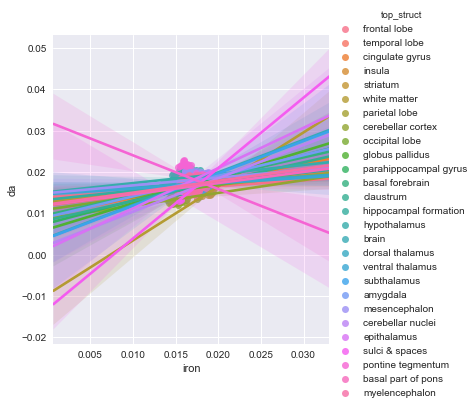

In [23]:
lm = sns.lmplot(data= df, x='iron', y ='da', hue='top_struct',
                #palette=sns.color_palette("coolwarm", len(all_structures 
               )


# Gene-set fixed effect correlations

In [24]:
cmap = sns.xkcd_palette(["windows blue", "amber", "greyish", "faded green", "dusty purple"])
def plot(df, met1,met2, plot_struct=False):
    sns.jointplot(df[met1], df[met2], kind = 'reg')
    if plot_struct:
        sns.jointplot(df_striatum[met1],  df_striatum[met2], kind = 'reg',color=cmap[0])
        sns.jointplot(df_frontal[met1],   df_frontal[met2],  kind = 'reg',color=cmap[1])
        sns.jointplot(df_parietal[met1],  df_parietal[met2], kind = 'reg',color=cmap[2])
        sns.jointplot(df_temporal[met1],  df_temporal[met2], kind = 'reg',color=cmap[3])
        sns.jointplot(df_occipital[met1], df_occipital[met2], kind = 'reg',color=cmap[4])


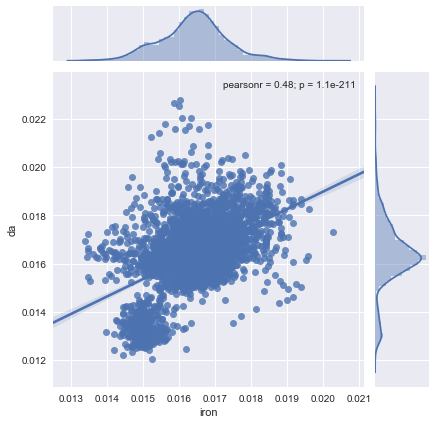

In [25]:
plot(df, 'iron','da')

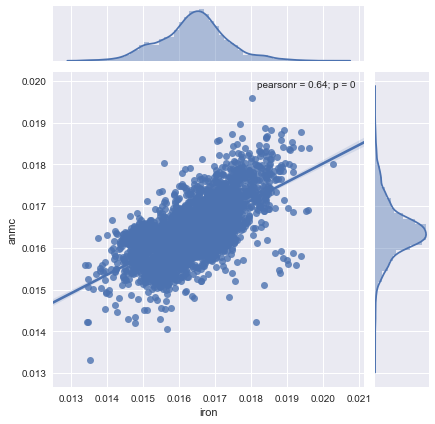

In [26]:
plot(df, 'iron','anmc', plot_struct=0)

# Lets look at gene-set correlations with patient-control QSM t-stats

In [27]:
mni_coordinates = get_mni_coordinates_from_wells(df.index)

In [28]:
import nibabel as nb 

mni_brain = nb.load('/usr/local/fsl/data/standard/MNI152_T1_1mm.nii.gz')
mni_data  = mni_brain.get_data()
mni_aff   = mni_brain.affine
mni_empty = np.zeros(mni_data.shape)

In [29]:
nifti_values = get_values_at_locations(nifti_file = os.path.join(statsdir, 'randomise_tstat1.nii.gz'), 
                                       locations= mni_coordinates, 
                                       radius=2, 
                                       verbose=True,)

No mask provided - using implicit (not NaN, not zero) mask


/Users/kanaan/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log1p
  """Entry point for launching an IPython kernel.


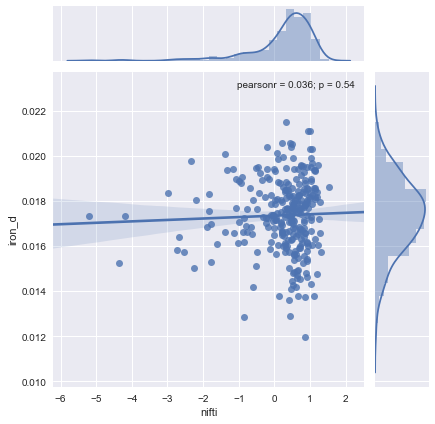

In [30]:
df['nifti'] = np.log1p(nifti_values)
plot(df, 'nifti','iron_d')

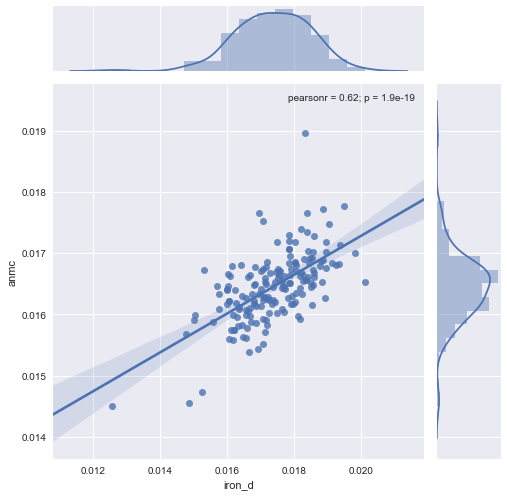

In [31]:
met1 = 'iron_d'
met2 = 'anmc'
g = sns.jointplot(df_striatum[met1], df_striatum[met2], kind = 'reg', size=7)

#cmap=['r','g','y','k']
#for i, dfx in enumerate([df_striatum, df_frontal, df_temporal, df_occipital]):
#    g.x = dfx[met1]
#    g.y = dfx[met2]
#    g.plot_joint(plt.scatter, c=cmap[i], s=20)


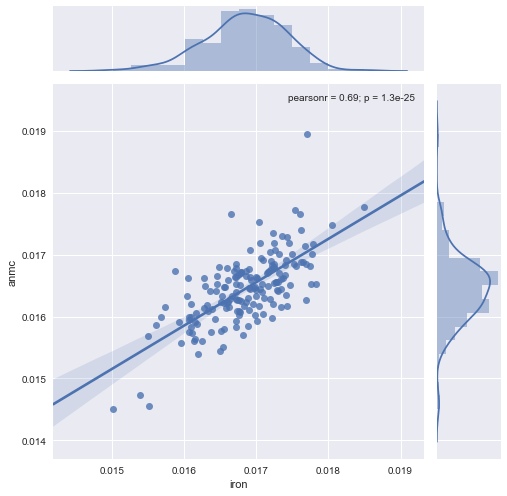

In [45]:
met1 = 'iron'
met2 = 'anmc'
g = sns.jointplot(df_striatum[met1], df_striatum[met2], kind = 'reg', size=7)

#cmap=['r','g','y','k']
#for i, dfx in enumerate([df_striatum, df_frontal, df_temporal, df_occipital]):
#    g.x = dfx[met1]
#    g.y = dfx[met2]
#    g.plot_joint(plt.scatter, c=cmap[i], s=20)


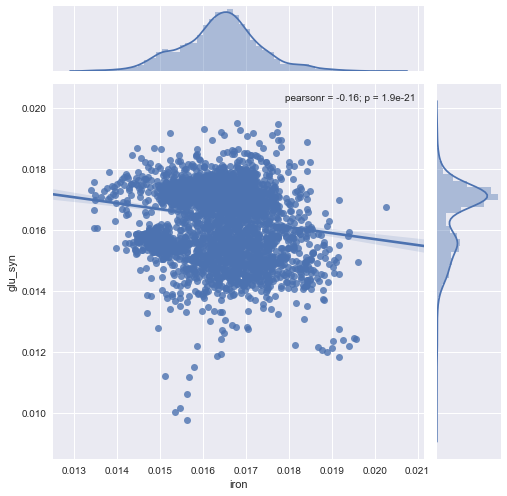

In [32]:
met1 = 'iron'
met2 = 'glu_syn'
g = sns.jointplot(df[met1], df[met2], kind = 'reg', size=7)

#cmap=['r','g','y','k']
#for i, dfx in enumerate([df_striatum, df_frontal, df_temporal, df_occipital]):
#    g.x = dfx[met1]
#    g.y = dfx[met2]
#    g.plot_joint(plt.scatter, c=cmap[i], s=20)


/Users/kanaan/anaconda/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


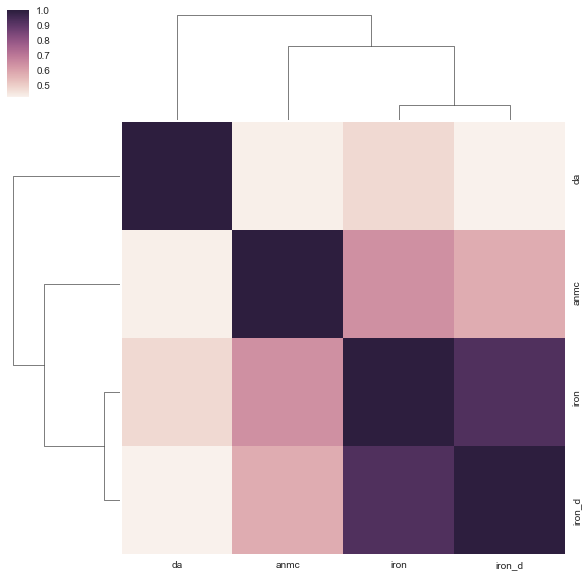

In [33]:
sns.clustermap(df.drop(['top_struct', 'struct', 'mni','nifti', 'glu','gaba','glu_syn'],axis=1).corr())

In [34]:
drop=['struct_id', 'struct_name', 'Mean', 'Median', 'PCA', 'corrected_mni_x', #'top_struct', 
      'corrected_mni_y', 'corrected_mni_z', 'coords_native', 'donor_names']

df_iron_drop = df_iron.drop(drop,axis=1)
df_iron_drop.head()

,FTH1_A_24_P919330,FTH1_A_32_P111565,FTH1_A_32_P820503,FTL_A_23_P50498,FTL_A_23_P50504,FTL_A_32_P155247,FTL_A_32_P158433,FTL_CUST_4420_PI416261804,HFE2_A_23_P86315,HFE2_CUST_14045_PI416261804,HFE2_CUST_14048_PI416261804,HFE2_CUST_14051_PI416261804,HFE2_CUST_14052_PI416261804,HFE_A_23_P145204,HFE_A_23_P342009,HFE_A_24_P103448,HFE_A_24_P111996,HFE_A_24_P289648,HFE_A_24_P354748,IL1A_A_23_P72096,IL1A_CUST_16163_PI416261804,IL6R_A_24_P379413,IL6R_CUST_14998_PI416261804,IL6_A_23_P71037,IL6_CUST_15487_PI416261804,IREB2_A_23_P106497,IREB2_A_24_P188005,IREB2_A_32_P421898,SLC40A1_A_23_P102391,SLC40A1_A_32_P151454,TFR2_A_23_P122896,TFR2_CUST_14038_PI416261804,TF_A_23_P212500,TF_A_23_P212508,TF_A_32_P42137,TNF_A_23_P376488,TNF_A_24_P50759,top_struct
1001,11.6052,13.6098,13.8664,11.0665,10.1561,10.4538,6.6165,13.6209,1.7583,1.5450,2.5337,1.5296,1.4950,1.5508,1.5572,1.5096,2.6230,1.9797,3.5558,2.4057,1.5398,4.4187,3.4631,1.4957,2.1803,8.1842,1.4767,1.6009,5.7264,1.5221,5.6650,2.5472,13.9486,9.4268,1.4767,3.2833,2.7505,frontal lobe
1002,11.4327,14.1971,14.2205,11.3791,10.6794,10.6520,6.6735,14.1435,1.7940,1.7348,2.3749,1.9142,2.1715,1.8449,1.6734,1.4767,3.9782,1.5221,1.5652,1.9969,1.9459,4.7540,3.9363,1.7630,2.2517,8.1055,1.6625,1.8012,6.0338,1.7633,6.3665,1.6042,14.1906,10.2928,2.7480,2.5042,4.2329,frontal lobe
1003,11.6800,13.7151,13.8130,11.5674,10.6704,10.6987,6.5169,13.9311,1.9174,1.6837,2.0963,1.8846,1.5686,1.8991,1.8696,1.5740,3.5114,2.2100,2.4094,1.9145,1.6742,4.1628,3.1540,2.9965,2.2156,8.4535,1.7140,1.9080,5.1996,1.8274,5.6247,1.7364,12.7086,8.1329,1.5252,3.2262,4.1010,temporal lobe
1004,11.0197,13.7976,13.8347,11.5105,10.3609,10.5455,6.5338,14.1227,1.9647,1.7494,2.3228,1.9238,1.6714,1.8879,1.7716,2.5628,3.9728,1.6885,2.6065,1.9057,1.6728,3.7809,3.3852,2.7408,2.1531,8.3325,1.7033,1.7336,5.1777,1.7892,6.3483,1.8428,11.8414,7.6308,1.4957,2.7726,4.0023,temporal lobe
1005,10.7983,13.6835,13.8894,11.3100,9.7466,10.1285,6.4039,13.8226,1.8947,1.6577,2.5168,1.7684,1.5443,1.7926,2.1896,2.3797,4.9600,1.7976,2.0615,1.7514,1.6501,4.2623,3.2054,1.6911,2.6579,8.5986,1.5910,1.8515,5.4620,1.6849,6.2336,1.7066,13.2051,8.5525,1.5268,1.4767,3.2756,cingulate gyrus


In [35]:
df_iron_drop_mean=df_iron_drop.groupby('top_struct', as_index=True).mean()
df_iron_drop_mean.head()
#sns.heatmap(df_iron_drop_mean.corr())

,FTH1_A_24_P919330,FTH1_A_32_P111565,FTH1_A_32_P820503,FTL_A_23_P50498,FTL_A_23_P50504,FTL_A_32_P155247,FTL_A_32_P158433,FTL_CUST_4420_PI416261804,HFE2_A_23_P86315,HFE2_CUST_14045_PI416261804,HFE2_CUST_14048_PI416261804,HFE2_CUST_14051_PI416261804,HFE2_CUST_14052_PI416261804,HFE_A_23_P145204,HFE_A_23_P342009,HFE_A_24_P103448,HFE_A_24_P111996,HFE_A_24_P289648,HFE_A_24_P354748,IL1A_A_23_P72096,IL1A_CUST_16163_PI416261804,IL6R_A_24_P379413,IL6R_CUST_14998_PI416261804,IL6_A_23_P71037,IL6_CUST_15487_PI416261804,IREB2_A_23_P106497,IREB2_A_24_P188005,IREB2_A_32_P421898,SLC40A1_A_23_P102391,SLC40A1_A_32_P151454,TFR2_A_23_P122896,TFR2_CUST_14038_PI416261804,TF_A_23_P212500,TF_A_23_P212508,TF_A_32_P42137,TNF_A_23_P376488,TNF_A_24_P50759
top_struct,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
amygdala,11.665890,13.350158,14.157190,11.632170,10.287131,10.740997,7.838530,14.647673,1.678891,1.833896,1.881561,1.946879,1.420555,1.889807,1.579967,1.975161,2.421588,1.929088,3.179416,2.386285,1.669633,4.526230,2.736076,2.515749,2.303843,8.056263,1.550415,1.813985,6.520501,1.800193,5.624727,1.841166,13.622778,9.982260,2.501224,2.122328,4.000307
basal forebrain,11.731159,13.146494,13.973251,11.412820,10.166082,10.626773,7.592361,14.415369,1.588359,1.594094,1.530627,1.736253,1.373604,1.874176,1.494122,1.622876,2.090969,1.614929,3.053022,3.367639,2.122978,5.041502,3.111090,2.370110,2.229849,8.260243,1.410984,1.702935,7.050992,1.601157,5.531418,1.684957,14.411794,10.876367,2.663739,1.710198,4.330639
basal part of pons,11.450065,13.162862,13.808158,10.731477,9.405165,9.817102,7.309767,13.910769,1.531560,1.557917,1.533406,1.619710,1.316735,1.732340,1.665475,1.521683,2.046154,1.590160,3.132546,2.553069,1.579615,5.797308,4.158319,2.447435,1.847223,7.830381,1.562556,1.823365,6.371792,1.578967,5.754102,1.738846,15.095808,12.046071,4.071017,1.737606,5.250283
brain,11.623533,13.189267,14.058067,11.436300,10.165000,10.610833,7.227300,14.314233,1.402833,1.359767,1.984600,2.214867,1.029767,1.876333,1.292433,1.701400,2.626400,1.430633,3.533933,2.056633,1.669733,4.611067,2.185633,3.851467,2.595533,8.500300,1.932633,2.262300,6.390200,1.358933,5.603667,1.219300,13.826000,10.279867,1.659433,1.547900,4.619100
cerebellar cortex,10.792711,12.306036,12.678604,10.270385,9.560071,9.813915,6.064183,13.338279,1.509395,1.610005,1.625820,1.751102,1.310082,1.624639,1.440930,1.741387,2.717493,1.775874,3.261438,1.404530,1.561241,3.143068,2.217383,1.921731,2.382455,8.384579,2.186462,2.408528,4.649808,1.440513,5.309570,2.874441,12.839168,9.117679,1.792549,1.756157,7.070634


In [36]:
dfxxx = pd.DataFrame(index = df_iron_drop_mean.index, columns = iron_homeostasis_gene_set.keys())

for gene in iron_homeostasis_gene_set.keys():
    print gene
    x = [df_iron_drop_mean[col] for col in df_iron_drop_mean if col[0:2]==gene[0:2]]
    dfxxx[gene] = pd.concat(x,axis=1).mean(axis=1)
    
dfxxx.corr()

TFR2
IL6R
TNF
IL1A
HFE
FTL
SLC40A1
HFE2
IL6
TF
FTH1
IREB2


,TFR2,IL6R,TNF,IL1A,HFE,FTL,SLC40A1,HFE2,IL6,TF,FTH1,IREB2
TFR2,1.000000,-0.092494,0.584337,-0.092494,-0.520901,0.549130,0.235192,-0.520901,-0.092494,1.000000,0.549130,-0.182644
IL6R,-0.092494,1.000000,-0.255092,1.000000,0.722810,0.469823,0.605102,0.722810,1.000000,-0.092494,0.469823,-0.396308
TNF,0.584337,-0.255092,1.000000,-0.255092,-0.303602,0.285720,-0.110118,-0.303602,-0.255092,0.584337,0.285720,0.149089
IL1A,-0.092494,1.000000,-0.255092,1.000000,0.722810,0.469823,0.605102,0.722810,1.000000,-0.092494,0.469823,-0.396308
HFE,-0.520901,0.722810,-0.303602,0.722810,1.000000,0.144647,0.387562,1.000000,0.722810,-0.520901,0.144647,-0.117147
FTL,0.549130,0.469823,0.285720,0.469823,0.144647,1.000000,0.391954,0.144647,0.469823,0.549130,1.000000,-0.477412
SLC40A1,0.235192,0.605102,-0.110118,0.605102,0.387562,0.391954,1.000000,0.387562,0.605102,0.235192,0.391954,-0.344443
HFE2,-0.520901,0.722810,-0.303602,0.722810,1.000000,0.144647,0.387562,1.000000,0.722810,-0.520901,0.144647,-0.117147
IL6,-0.092494,1.000000,-0.255092,1.000000,0.722810,0.469823,0.605102,0.722810,1.000000,-0.092494,0.469823,-0.396308
TF,1.000000,-0.092494,0.584337,-0.092494,-0.520901,0.549130,0.235192,-0.520901,-0.092494,1.000000,0.549130,-0.182644


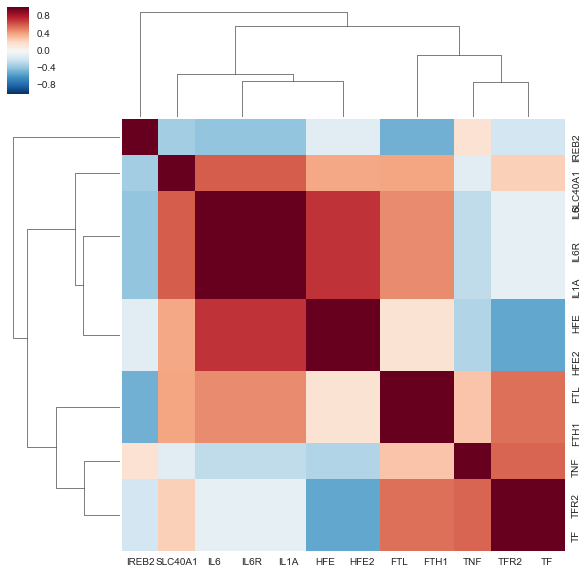

In [37]:
sns.clustermap(dfxxx.corr())

In [38]:
df_ftl = get_expression_df(['FTL'], 'ferritin')

In [39]:
df_ftl.head()

,FTL_A_23_P50498,FTL_A_23_P50504,FTL_A_32_P155247,FTL_A_32_P158433,FTL_CUST_4420_PI416261804,coords_native,donor_names,struct_id,struct_name,top_struct,Mean,Median,PCA,corrected_mni_x,corrected_mni_y,corrected_mni_z
1001,11.0665,10.1561,10.4538,6.6165,13.6209,"[66, 46, 97]",H0351.2001,4033,"middle frontal gyrus, right, superior bank of ...",frontal lobe,10.38276,10.4538,0.015911,29.911739,-2.115836,46.858706
1002,11.3791,10.6794,10.6520,6.6735,14.1435,"[124, 40, 89]",H0351.2001,4031,"middle frontal gyrus, left, inferior bank of g...",frontal lobe,10.70550,10.6794,0.016427,-34.143679,3.115101,53.592671
1003,11.5674,10.6704,10.6987,6.5169,13.9311,"[34, 118, 109]",H0351.2001,4154,"inferior temporal gyrus, right, lateral bank o...",temporal lobe,10.67690,10.6987,0.016382,63.768605,-40.606923,-27.030654
1004,11.5105,10.3609,10.5455,6.5338,14.1227,"[143, 122, 105]",H0351.2001,4150,"inferior temporal gyrus, left, lateral bank of...",temporal lobe,10.61468,10.5455,0.016312,-55.572538,-39.520167,-31.188580
1005,11.3100,9.7466,10.1285,6.4039,13.8226,"[96, 67, 90]",H0351.2001,4231,"cingulate gyrus, parietal part, left, inferior...",cingulate gyrus,10.28232,10.1285,0.015815,-2.423746,-2.759299,27.899077


In [40]:
mni_coordinates = get_mni_coordinates_from_wells(df_ftl.index)
nifti_values = get_values_at_locations(#nifti_file = os.path.join(statsdir, 'randomise_tstat1.nii.gz'), 
                                       nifti_file = '/Users/kanaan/SCR/workspace/tmp/mean.nii.gz',
                                       locations = mni_coordinates, 
                                       radius  = 2, 
                                       verbose = True,)

No mask provided - using implicit (not NaN, not zero) mask


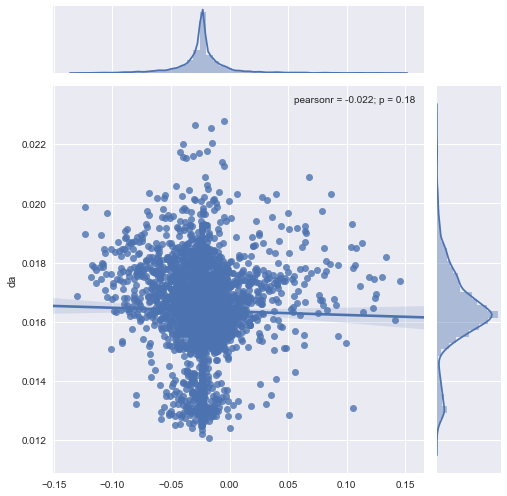

In [41]:
sns.jointplot( np.array(nifti_values), df.da, kind = 'reg', size=7)

In [42]:
df_striatum.head()

,iron,da,glu,gaba,anmc,top_struct,struct,mni,iron_d,glu_syn
1028,0.017766,0.017606,0.014523,0.015265,0.016529,striatum,"putamen, left","(-30.06483899, -30.06483899, -30.06483899)",0.018847,0.017065
11254,0.016043,0.016885,0.013877,0.016151,0.016339,striatum,"nucleus accumbens, left","(-13.58861393, -13.58861393, -13.58861393)",0.015752,0.016304
11278,0.016976,0.016766,0.014030,0.015223,0.016459,striatum,"head of caudate nucleus, left","(-13.294641, -13.294641, -13.294641)",0.017677,0.017073
11301,0.016700,0.017223,0.014076,0.015982,0.016743,striatum,"head of caudate nucleus, left","(-16.72903106, -16.72903106, -16.72903106)",0.017081,0.017267
11333,0.017070,0.017477,0.013988,0.015528,0.016948,striatum,"head of caudate nucleus, left","(-11.96353827, -11.96353827, -11.96353827)",0.017876,0.017478


In [43]:
df_fth = get_expression_df(['FTH1'], 'ferritin_heavy')

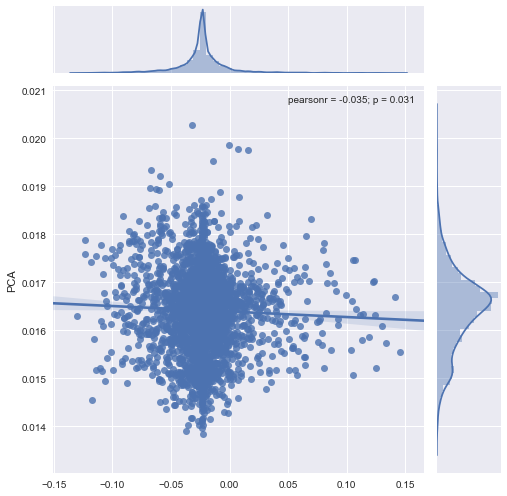

In [44]:
sns.jointplot( np.array(nifti_values), df_fth['PCA'], kind = 'reg', size=7)